In [24]:
import h5py, os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from ecog.utils.electrodes import load_electrode_labels
from ecog.utils import bands
from ecog.tokenize.transcripts import parse, make_df
from ecog.signal_processing import zscore, gaussian, hilbert_transform

from cv_paper_plots import pipeline_analysis as analysis
from cv_paper_plots.pipeline_analysis import make_slice, make_colors, make_bracket

In [25]:
subj_path = os.path.join(os.environ['HOME'], 'Development/data/ecog/EC2')
block = 'EC2_B1'
block_path = os.path.join(subj_path, block)
rate = 400

anatomy = load_electrode_labels(subj_path)
vsmc_idxs = np.array([idx for idx, a in enumerate(anatomy) if a in ['preCG', 'postCG']])

ec2_b1_transcript_parse = parse(block_path, block)
ec2_b1_transcript = make_df(ec2_b1_transcript_parse, 1, 'EC2', 1)

In [47]:
with h5py.File(os.path.join(block_path, 'ecog400/ecog.h5')) as f:
    raw_vsmc_data = f['ecogDS/data'][sorted(vsmc_idxs)]
vsmc_data, means, stds = zscore(raw_vsmc_data, mode='file', sampling_freq=400., block_path=block_path)

In [48]:
cfs = bands.chang_lab['cfs']
stds = bands.chang_lab['sds']

minf, maxf = bands.neuro['min_freqs'][-1], bands.neuro['max_freqs'][-1]
filters = [gaussian(vsmc_data, rate, c, s) for c, s in zip(cfs, stds) if ((c >= minf) and (c <= maxf))]
ht = np.squeeze(abs(hilbert_transform(vsmc_data, rate, filters)))
print(ht.shape)
ht, m, s = zscore(ht, mode='file', sampling_freq=400., block_path=block_path)
ht = ht.mean(axis=0) / 2 

(7, 88, 258801)


In [49]:
temp_data = []
for ii in ec2_b1_transcript.index:
    temp_data.append(ht[:, make_slice(ii, ec2_b1_transcript, rate)])
temp_data = np.stack(temp_data)

In [61]:
_idx, elec_idx, _ = np.unravel_index(np.argmax(temp_data), temp_data.shape)
idx = ec2_b1_transcript.index[_idx]
channel_slice = slice(elec_idx-5, elec_idx+5)
sl = make_slice(idx, ec2_b1_transcript, rate)
cv_data = vsmc_data[:, sl]

# Electrodes by time

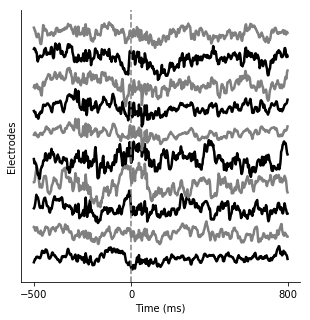

In [62]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_electrodes_by_time(cv_data[channel_slice], ax)
plt.savefig('/home/jesse/Downloads/electrodes.pdf')

# Bandpassed electrode

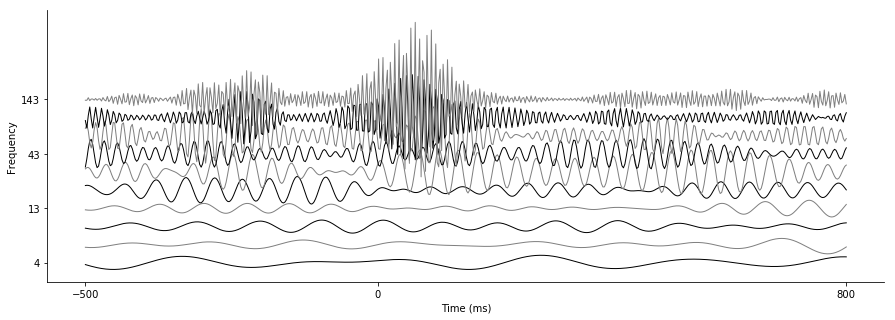

In [63]:
elec_data = vsmc_data[[elec_idx]]
band_idxs = np.arange(0, 40, 4)

plt.close()
f, ax = plt.subplots(1, figsize=(15, 5))
analysis.plot_40bands_by_time(elec_data, band_idxs, sl, rate, block_path, ax)
plt.savefig('/home/jesse/Downloads/frequencies.pdf')

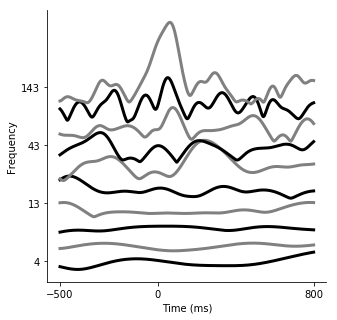

In [71]:
elec_data = vsmc_data[[elec_idx]]
band_idxs = np.arange(0, 40, 4)

plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_40bandsAA_by_time(elec_data, band_idxs, sl, rate, block_path, ax)
plt.savefig('/home/jesse/Downloads/frequenciesAA.pdf')

# Neuro bands

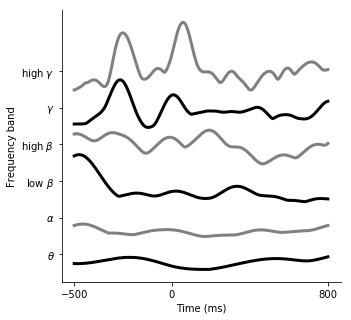

In [72]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_neurobands_by_time(elec_data, sl, rate, block_path, ax)
plt.savefig('/home/jesse/Downloads/bands.pdf')

# Dataset

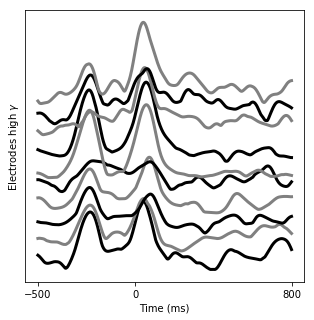

In [73]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_datapoints(vsmc_data[channel_slice], [sl], rate, block_path, [ax])
plt.savefig('/home/jesse/Downloads/data.pdf')

# Network

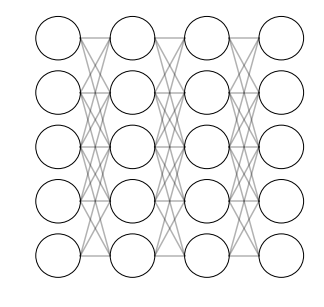

In [74]:
plt.close()
figsize = (5, 5)
f, ax = plt.subplots(1, figsize=figsize)
analysis.plot_network(5, 4, ax)
#plt.savefig('/home/jesse/Downloads/bands.pdf')

# Normal pipeline

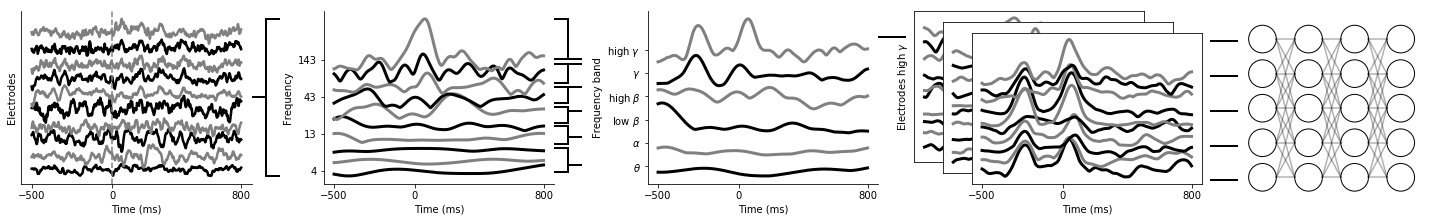

In [78]:
figsize = (20, 3)
x2y = figsize[0] / figsize[1]
f = plt.figure(figsize=figsize)

height = .8
width_square = height / x2y

width = .16

ax0 = f.add_axes([.02, .15, width, height])
ax1 = f.add_axes([.23, .15, width, height])
ax2 = f.add_axes([.455, .15, width, height])
n_data = 3
data_axes = [f.add_axes([.64+(ii*.02), .25-(ii*.05), width, .7]) for ii in range(n_data)]
axn = f.add_axes([.87, .1, width_square, height])

analysis.plot_electrodes_by_time(baa_data[channel_slice], ax0)
analysis.plot_40bandsAA_by_time(elec_data, band_idxs, sl, rate, block_path, ax1)
analysis.plot_neurobands_by_time(elec_data, sl, rate, block_path, ax2)
analysis.plot_datapoints(vsmc_data[channel_slice], [make_slice(idx, ec2_b1_transcript, rate) for idx in [2, 23, idx]],
                         rate, block_path, data_axes)
analysis.plot_network(5, 4, axn)

bax0 = f.add_axes([.18, .15, .02, height])
make_bracket([.5], [0, 1], bax0)

bax1_t = f.add_axes([.39, .2, .02, .12])
make_bracket([0, 1], [.3], bax1_t)
bax1_a = f.add_axes([.39, .33, .02, .09])
make_bracket([0, 1], [.4], bax1_a)
bax1_lb = f.add_axes([.39, .43, .02, .08])
make_bracket([0, 1], [.75], bax1_lb)
bax1_hb = f.add_axes([.39, .52, .02, .08])
make_bracket([0, 1], [1], bax1_hb)
bax1_g = f.add_axes([.39, .61, .02, .1])
make_bracket([0, 1], [1], bax1_g)
bax1_hg = f.add_axes([.39, .72, .02, .2])
make_bracket([0, 1], [0], bax1_hg)

ax_select = f.add_axes([.615, .15, .02, height])
y = .85
ax_select.plot([0, 1], [y, y], 'k', lw=2)
ax_select.set_ylim(0, 1)
ax_select.axis('off')

ax_data = f.add_axes([.845, .15, .02, height])
for y in np.linspace(.02, .825, 5):
    ax_data.plot([0, 1], [y, y], 'k', lw=2)
ax_data.set_ylim(0, 1)
ax_data.axis('off')

plt.savefig('/home/jesse/Downloads/normal_pipeline.pdf')